Assigment-2 Deep FMI - Convolutional Neural Networks

Import necessary libraries

In [182]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

from typing import Iterator, List, Callable, Tuple
import matplotlib.pyplot as plt
import numpy as np
import math
from random import sample

from IPython.core.debugger import set_trace
import time

Set the parameters for training

In [183]:
lr = 0.001
momentum = 0.9
num_epochs = 5
batch_size = 8
num_cls = 10

Load **CIFAR-10** dataset

In [184]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./ds', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./ds', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


# **TASK 1**. Define a standard convolutional network

In [185]:
class CNNModel(torch.nn.Module):
    def __init__(self, out_size):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features = 5 * 5 * 16, out_features=128) 
        self.fc2 = nn.Linear(in_features = 128, out_features = 64)
        self.output = nn.Linear(in_features = 64, out_features = out_size)
        self.activation_fn = nn.ReLU()

        
    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        out = self.output(x)
        return out

model = CNNModel(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# **TASK 2**. Training and evaluation

In [186]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device=None):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)
    
    for batch_idx, batch in tqdm(enumerate(train_dataloader)):
        batch_img, batch_labels = batch
        
        # move data to GPU
        batch_img = batch_img.to(device)
        batch_labels = batch_labels.to(device)
        
        # initialize as zeros all the gradients of the model
        model.zero_grad()

        # get predictions from the FORWARD pass 
        output = model(batch_img)

        loss = loss_crt(output, batch_labels.squeeze())       
        loss_scalar = loss.item()

        # BACKPROPAGATE the gradients
        loss.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()
        
        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()
        
    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy


def eval_epoch(model, val_dataloader, loss_crt, device=None, N=None):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            batch_img, batch_labels = batch
            current_batch_size = batch_img.size(0)

            # move data to GPU
            batch_img = batch_img.to(device)
            batch_labels = batch_labels.to(device)
 
            output = model(batch_img)

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

            if N and batch_idx > N:
              break

    epoch_loss = epoch_loss/num_batches
    if N is None:
      epoch_accuracy = 100. * epoch_accuracy/num_batches
    else:
      epoch_accuracy = 100. * epoch_accuracy/N
    return epoch_loss, epoch_accuracy

In [187]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
  train_loss, train_accuracy = train_epoch(model, trainloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(model, testloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy)) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
6250it [00:48, 127.71it/s]
1250it [00:06, 182.56it/s]


Epoch 0
train loss: 1.76627847, accuracy: 35.80000000
val loss: 1.47388633, accuracy: 46.55000000



6250it [00:49, 126.05it/s]
1250it [00:06, 180.40it/s]


Epoch 1
train loss: 1.34579969, accuracy: 52.06400000
val loss: 1.27962590, accuracy: 54.46000000



6250it [00:49, 126.05it/s]
1250it [00:07, 171.64it/s]


Epoch 2
train loss: 1.19646716, accuracy: 57.80400000
val loss: 1.17212588, accuracy: 58.35000000



6250it [00:49, 125.75it/s]
1250it [00:06, 182.94it/s]


Epoch 3
train loss: 1.09306902, accuracy: 61.50000000
val loss: 1.16956604, accuracy: 59.42000000



6250it [00:49, 126.52it/s]
1250it [00:06, 178.99it/s]


Epoch 4
train loss: 1.00836124, accuracy: 64.47000000
val loss: 1.08437466, accuracy: 61.70000000


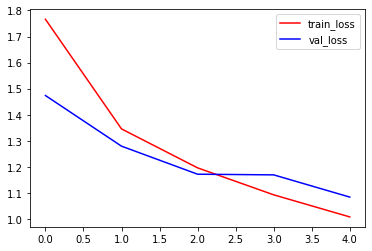

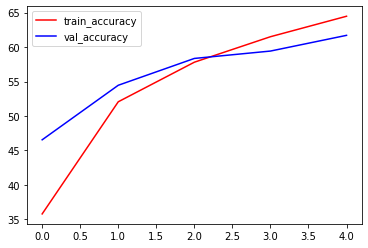

In [188]:
# plot loss & accuracy
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.plot(val_losses, label='val_loss', color='blue')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train_accuracy', color='red')
plt.plot(val_accuracies, label='val_accuracy', color='blue')
plt.legend()
plt.show()

# **TASK 3**. Implement a linear layer. 

In [189]:
import pdb
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, device=None):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    # initialise parameters
    # weight shape: [in, out]
    # bias shape: [out]
    
    self.weight = torch.nn.parameter.Parameter(
        torch.empty(out_features, in_features)
        #torch.empty((out_features, in_features))
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.empty(out_features)
    )

    self.reset_parameters()
 
  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_features)
    nn.init.uniform(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):
    out = []
    with torch.no_grad():
      for sample in x:
        x = np.matmul(self.weight.cpu(), sample.cpu())
        x = x.to(device)
        x = x + self.bias
        out.append(x)

    out = torch.stack(out)
    out = out.to(device)
    return out

In [190]:
linear = nn.Linear(8, 16)
my_linear = myLinear(8, 16)
my_linear.load_state_dict(linear.state_dict())
linear = linear.to(device)
my_linear = my_linear.to(device)

input = torch.rand(5, 8)
input = input.to(device)

out1 = linear.forward(input)
out2 = my_linear.forward(input)
print((out1-out2).mean())

tensor(-5.3551e-09, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


# **Task 4**. Implement Conv2d layer

In [191]:
class myConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, device=None):
    super(myConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    # initialise parameters
    scale = 1.0 / math.sqrt(in_channels * kernel_size * kernel_size)
    self.weight = torch.nn.parameter.Parameter(
        torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        #torch.empty((out_features, in_features))
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.rand(out_channels)
    )

    self.reset_parameters()
 
  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_channels * self.kernel_size * self.kernel_size )
    nn.init.uniform(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):
    out = []
    with torch.no_grad():
      for sample in x:
        _, in_height, in_width = sample.shape
        out_height = in_height - self.kernel_size + 1
        out_width = in_width - self.kernel_size + 1
        result = torch.zeros((self.out_channels, out_height, out_width))

        for k in range(self.out_channels):
          for i in range(out_height):
            for j in range(out_width):
              image_crop = sample[:, i:i+self.kernel_size, j:j+self.kernel_size]
              result[k, i, j] = torch.sum(image_crop*self.weight[k, :,:,:])
              result = result.to(device)
        out.append(result)

    out = torch.stack(out)
    out = out.to(device)
    return out


In [192]:
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
my_conv = myConv2d(in_channels=3, out_channels=6, kernel_size=5)
my_conv.load_state_dict(conv.state_dict())
conv = conv.to(device)
my_conv = my_conv.to(device)

input = torch.rand(10, 3, 16, 16)
input = input.to(device)

out1 = conv.forward(input)
out2 = my_conv.forward(input)
print((out1-out2).mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>)


# **TASK 5**. Evaluate your implementation of convolutional network. 

In [193]:
class mySimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = myConv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = myConv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = myLinear(in_features = 5 * 5 * 16, out_features=128) 
        self.fc2 = myLinear(in_features = 128, out_features = 64)
        self.output = myLinear(in_features = 64, out_features = out_size)
        self.activation_fn = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        out = self.output(x)
        return out


my_model = mySimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.


In [194]:
my_model.load_state_dict(model.state_dict())
optimizer = torch.optim.SGD(my_model.parameters(), lr=lr, momentum=momentum)
loss_criterion = nn.CrossEntropyLoss()

val_losses = []
val_accuracies = []

start_model = time.perf_counter()
val_loss, val_accuracy = eval_epoch(model, testloader, loss_criterion, device, 19)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy)) 
end_model = time.perf_counter()
print('Default model time performance (s): %10.8f'%(end_model-start_model))

start_my_model = time.perf_counter()
val_loss, val_accuracy = eval_epoch(my_model, testloader, loss_criterion, device, 19)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy)) 
end_my_model = time.perf_counter()
print('Own model time performance (s): %10.8f'%(end_my_model-start_my_model))

time_ratio = (end_model-start_model) / (end_my_model-start_my_model)
print('Ratio: %10.8f'%time_ratio)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
20it [00:00, 154.65it/s]


val loss: 0.01767258, accuracy: 69.07894737
Default model time performance (s): 0.39568703


20it [02:11,  6.57s/it]

val loss: 0.02666217, accuracy: 51.31578947
Own model time performance (s): 131.67794246
Ratio: 0.00300496


# **TASK 6**. Feature map visualization

Define function to show and title an image

In [202]:
def visualize_feature_maps(img, layer):
  for i in range(3):
    f, axarr = plt.subplots(1,5)
    f.suptitle('Layer %s Img %d'%(layer,i))
    for j in range(5):
      axarr[j].imshow(img[i,j,:,:])
      axarr[j].set_title('channel %d'%j)

In [203]:
class VisualizeModel(torch.nn.Module):
    def __init__(self, out_size):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features = 5 * 5 * 16, out_features=128) 
        self.fc2 = nn.Linear(in_features = 128, out_features = 64)
        self.output = nn.Linear(in_features = 64, out_features = out_size)
        self.activation_fn = nn.ReLU()

        
    def forward(self, input):
        x = self.conv1(input)
        visualize_feature_maps(x[:3], "conv1")
        x = self.maxpool(x)
        visualize_feature_maps(x[:3], "maxpool1")
        x = self.conv2(x)
        visualize_feature_maps(x[:3], "conv2")
        x = self.maxpool(x)
        visualize_feature_maps(x[:3], "maxpool2")
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))
        out = self.output(x)
        return out

vmodel = VisualizeModel(out_size=num_cls)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

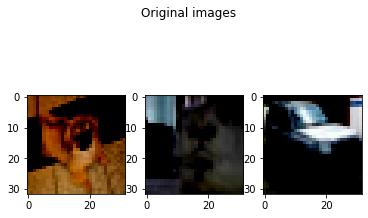

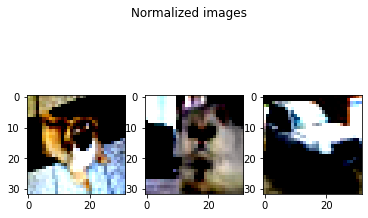

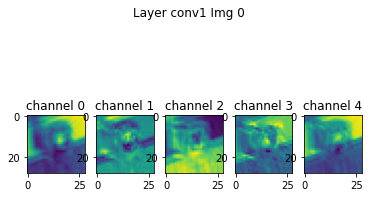

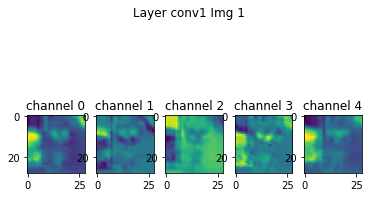

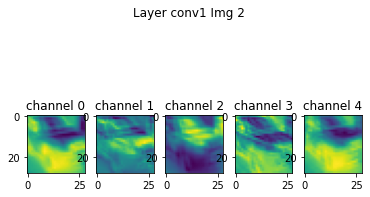

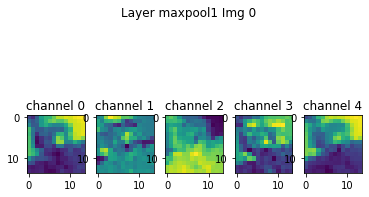

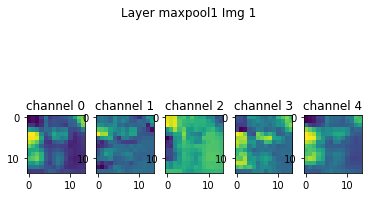

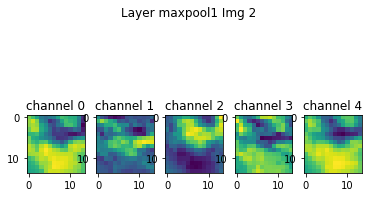

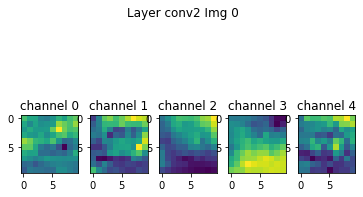

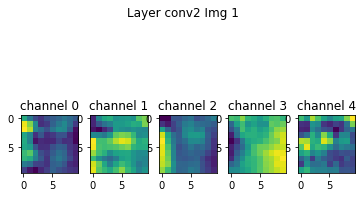

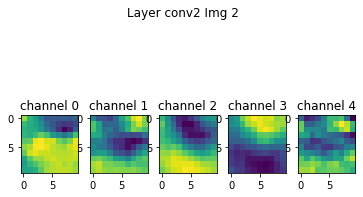

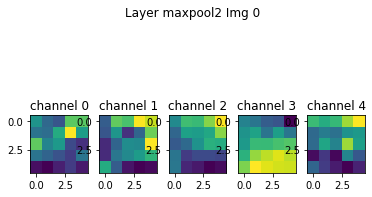

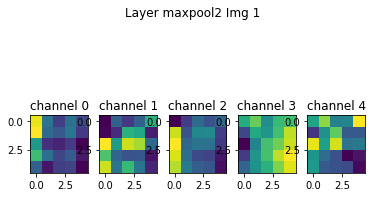

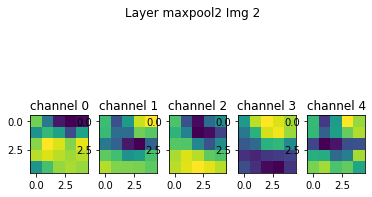

In [218]:
import cv2


batch, _ = next(iter(trainloader))

f, axarr = plt.subplots(1, 3)
f.suptitle("Original images")
axarr[0].imshow(batch[0].permute(1,2,0))
axarr[1].imshow(batch[1].permute(1,2,0))
axarr[2].imshow(batch[2].permute(1,2,0))

normalized = []
for i in range(3):
  mean, std = batch[i].mean([1,2]), batch[i].std([1,2])
  transform_norm = transforms.Compose([
    transforms.Normalize(mean, std)
  ])
  img = transform_norm(batch[i])
  normalized.append(img)
normalized = torch.stack(normalized)

f, axarr = plt.subplots(1, 3)
f.suptitle("Normalized images")
axarr[0].imshow(normalized[0].permute(1,2,0))
axarr[1].imshow(normalized[1].permute(1,2,0))
axarr[2].imshow(normalized[2].permute(1,2,0))

with torch.no_grad():
  vmodel(batch[:3])